In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
except:
	pass


 ## Car and Real MPG over time
 The following plot shows the distribution of miles-per-gallon (MPG) over time.
 I was able to record two different MPG values:
 * **Car MPG**: The average MPG for a single tank as reported by my car's dashboard
 * **Real MPG**: The MPG calculated by dividing the number of miles I drove
   (reported by my car) divided by the number of gallons I put in after that
   drive

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Some extra stuff to stop complaints when plotting the data column
from  pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [3]:
# Load the data
db = pd.read_pickle('data/data_formatted.pkl')

# Trim the NaN values
db = db.drop(['notes'], axis=1)
db = db[~db.isin([np.nan]).any(1)]


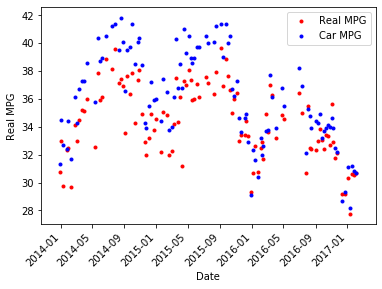

In [4]:
# Setup the axes
plt.xlabel('Date')
plt.ylabel('Real MPG')
plt.xticks(rotation=45, ha='right')
plt.scatter(db.Date, db['Real MPG'], color='red', marker='.', label='Real MPG')
plt.scatter(db.Date, db['Car MPG'], color='blue', marker='.', label='Car MPG')
plt.legend() # Identify the values


 Hmmm, that's a bit of a messy plot. It would be nice to have a sort of 'trend-
 line' that can guide the eye. I don't currently have anything that can do that,
 so let me go write a method really quick...

In [5]:
def moving_avg(x, nbins=2):
    """
    Generates a moving average of a given bin and 'nbins' on either side

    Parameters
    ----------
    x : numpy.array
        Array of values
    nbins : int
        Number of bins on either side to average
    
    Returns
    -------
    Array representing a moving average
    """
    y = np.array(x)
    y = np.insert(y, 0, [np.nan]*2*nbins)
    width = 2*nbins + 1
    return np.convolve(y, np.ones(width), 'valid') / width
   

In [6]:
mv_avg_real_mpg = moving_avg(np.array(db['Real MPG']))
mv_avg_car_mpg  = moving_avg(np.array(db['Car MPG']))


 There we go, so let's plot that all up

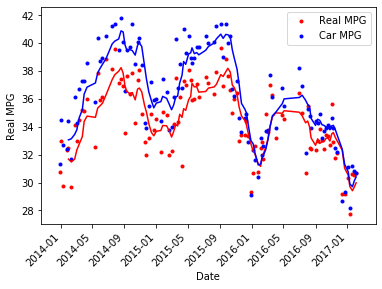

In [7]:
plt.xlabel('Date')
plt.ylabel('Real MPG')
plt.xticks(rotation=45, ha='right')
plt.scatter(db.Date, db['Real MPG'], color='red', marker='.', label='Real MPG')
plt.scatter(db.Date, db['Car MPG'], color='blue', marker='.', label='Car MPG')
plt.plot(db.Date, mv_avg_real_mpg, color='red', ls='-')
plt.plot(db.Date, mv_avg_car_mpg, color='blue', ls='-')
plt.legend() # Identify the values


 This is interesting. It looks like my car was reporting a higher value of MPG
 than I actually was using! That suggests my car was doing something funny.

 If we look, though, at 2016 it appears the difference between my car and the
 actual MPG get's a little closser together, so let's see if this is actually
 correct. I'll do that by plotting a distribution of 'Real-Car MPG'

In [8]:
# Get the 2014 data
db_2014 = db[db.Date < pd.datetime(2015,1,1)]
db_2014 = db_2014[db_2014.Date >= pd.datetime(2014,1,1)]
# Get the 2015 data
db_2015 = db[db.Date < pd.datetime(2016,1,1)]
db_2015 = db_2015[db_2015.Date >= pd.datetime(2015,1,1)]
# Get the 2016 data
db_2016 = db[db.Date < pd.datetime(2017,1,1)]
db_2016 = db_2016[db_2016.Date >= pd.datetime(2016,1,1)]
# Get the 2017 data
db_2017 = db[db.Date < pd.datetime(2018,1,1)]
db_2017 = db_2017[db_2017.Date >= pd.datetime(2017,1,1)]

# Function to compute percent offset
def off_prcnt(measured,real):
    return (measured-real)

# Generate an offset percentage
offset_vals = []
offset_labels = []
offset_vals.append(off_prcnt(db_2014['Car MPG'],db_2014['Real MPG']))
offset_vals.append(off_prcnt(db_2015['Car MPG'],db_2015['Real MPG']))
offset_vals.append(off_prcnt(db_2016['Car MPG'],db_2016['Real MPG']))
offset_vals.append(off_prcnt(db_2017['Car MPG'],db_2017['Real MPG']))
yr = 2014
for vals in offset_vals:
    # Remove NaNs
    vals = vals[~np.isnan(vals)]
    # Compute average and std. deviation
    avg = np.average(vals)
    sigma = np.var(vals)
    # Create the label
    offset_labels.append(r'{}: $\mu={:0.2f},\ \sigma={:0.2f}$'.format(yr, avg, sigma))
    yr += 1
colors = ['blue', 'green', 'red', 'yellow']


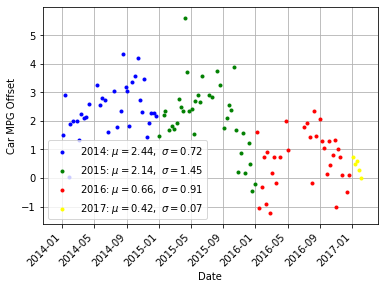

In [9]:
plt.xlabel('Date')
plt.ylabel('Car MPG Offset')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.scatter(db_2014.Date, offset_vals[0], 
            color='blue', marker='.', label=offset_labels[0], zorder=3)
plt.scatter(db_2015.Date, offset_vals[1], 
            color='green', marker='.', label=offset_labels[1], zorder=3)
plt.scatter(db_2016.Date, offset_vals[2], 
            color='red', marker='.', label=offset_labels[2], zorder=3)
plt.scatter(db_2017.Date, offset_vals[3], 
            color='yellow', marker='.', label=offset_labels[3], zorder=3)
plt.legend()


 Holdup ... what's that weird point in 2015 that appears to be REALLY high up?
 Let's do some investigation to find that one point

In [10]:
# Get all points in the distribution where the difference is more than 15 in 
# the 2015 distribution
outlier_indx = offset_vals[1].idxmax()
print(f'Outlier index: {outlier_indx}')
print(f'Outlier info:\n{db_2015.loc[[outlier_indx]]}')


Outlier index: 112
Outlier info:
          Date  Miles  Gas Pumped  Price/Gal  Car MPG  Avg Spd  Car gas  \
112 2015-04-10  419.8      13.462      2.259     36.8     46.8     12.5   

     Price/Barrel  Real MPG   paid ($)   Latitude  Longitude  
112         51.64    31.184  30.410658  41.586835 -93.624959  


 Okay, well, it doesn't look like there's anything particularly weird with that
 specific data point, so I guess I'll leave it be.

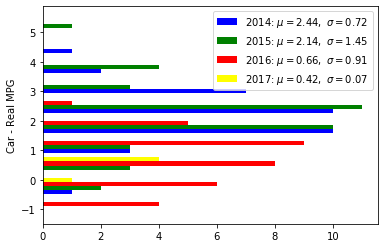

In [11]:
# Generate some histograms
plt.ylabel('Car - Real MPG')
plt.hist(offset_vals, 10, stacked=False, label=offset_labels, color=colors,
         orientation='horizontal')
plt.legend()


 From the looks of it, it appears that the MPG get's more and more accurate
 over time. I'm not sure why this is, it could be that there was a recall that
 happened sometime near the end of 2015. On the otherhand, it could be that my
 car decided to trust me with the "true" MPG. I don't know, but it's interesting
 to see that it did in fact change over time.